#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/project1/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# (Jupyter) 시각화 한글폰트 설정을 위해 아래 코드를 실행하세요.
plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [4]:
# 주어진 데이터 셋을 불러오세요.(3개)
path = './data/'
train_df = pd.read_csv(path + 'data01_train.csv')
test_df = pd.read_csv(path + 'data01_test.csv')
feature = pd.read_csv(path + 'features.csv')

In [5]:
# 불필요한 칼럼을 삭제하세요.
train_df = train_df.drop(columns=['subject'])
test_df = test_df.drop(columns=['subject'])

#### 2) 기본 정보 조회

In [6]:
# 전체 데이터의 행, 열 개수를 확인
display(train_df.shape)
display(test_df.shape)
display(feature.shape)

(5881, 562)

(1471, 562)

(561, 4)

In [7]:
# 전체 데이터의 상위 5개 행 확인
display(train_df.head())
display(test_df.head())
display(feature.head())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [8]:
# 전체 데이터의 수치형 변수 분포 확인
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
summary = train_df[numeric_cols].describe().T
summary['skew'] = train_df[numeric_cols].skew()   # 왜도
summary['kurt'] = train_df[numeric_cols].kurt()   # 첨도
display(summary.head(10))

numeric_cols2 = test_df.select_dtypes(include=['int64', 'float64']).columns
summary2 = test_df[numeric_cols2].describe().T
summary2['skew'] = test_df[numeric_cols2].skew()   # 왜도
summary2['kurt'] = test_df[numeric_cols2].kurt()   # 첨도
display(summary2.head(10))

numeric_cols3 = feature.select_dtypes(include=['int64', 'float64']).columns
display(numeric_cols3)

,count,mean,std,min,25%,50%,75%,max,skew,kurt
tBodyAcc-mean()-X,5881.0,0.274811,0.067614,-0.503823,0.262919,0.277154,0.288526,1.000000,-1.992708,25.270158
tBodyAcc-mean()-Y,5881.0,-0.017799,0.039422,-0.684893,-0.024877,-0.017221,-0.010920,1.000000,2.020631,170.002842
tBodyAcc-mean()-Z,5881.0,-0.109396,0.058373,-1.000000,-0.121051,-0.108781,-0.098163,1.000000,1.709861,90.980485
tBodyAcc-std()-X,5881.0,-0.603138,0.448807,-1.000000,-0.992774,-0.943933,-0.242130,1.000000,0.666620,-0.880765
tBodyAcc-std()-Y,5881.0,-0.509815,0.501815,-0.999844,-0.977680,-0.844575,-0.034499,0.916238,0.401020,-1.448083
tBodyAcc-std()-Z,5881.0,-0.604058,0.417319,-0.999667,-0.980127,-0.856352,-0.262690,1.000000,0.676910,-0.645706
tBodyAcc-mad()-X,5881.0,-0.628151,0.424345,-1.000000,-0.993602,-0.948501,-0.291138,1.000000,0.717206,-0.708937
tBodyAcc-mad()-Y,5881.0,-0.525944,0.485115,-0.999419,-0.977865,-0.849266,-0.068857,0.967664,0.404094,-1.439999
tBodyAcc-mad()-Z,5881.0,-0.605374,0.413043,-1.000000,-0.980112,-0.849896,-0.268539,1.000000,0.638990,-0.770888
tBodyAcc-max()-X,5881.0,-0.465490,0.544995,-1.000000,-0.936067,-0.878729,-0.013690,1.000000,0.620688,-1.139105


,count,mean,std,min,25%,50%,75%,max,skew,kurt
tBodyAcc-mean()-X,1471.0,0.273198,0.079989,-1.000000,0.263787,0.277322,0.288058,0.631510,-6.866798,99.738427
tBodyAcc-mean()-Y,1471.0,-0.017281,0.045957,-1.000000,-0.024792,-0.017187,-0.010238,0.359587,-6.526640,168.931137
tBodyAcc-mean()-Z,1471.0,-0.108123,0.049082,-0.418354,-0.120733,-0.108124,-0.096606,0.543939,2.233829,34.031729
tBodyAcc-std()-X,1471.0,-0.614634,0.448480,-0.999717,-0.992669,-0.952426,-0.245405,0.899922,0.721920,-0.800044
tBodyAcc-std()-Y,1471.0,-0.515427,0.506094,-0.999873,-0.979082,-0.867309,-0.030639,0.782590,0.425783,-1.470720
tBodyAcc-std()-Z,1471.0,-0.607533,0.424243,-1.000000,-0.981070,-0.869890,-0.260223,0.931308,0.752295,-0.479046
tBodyAcc-mad()-X,1471.0,-0.639950,0.422994,-0.999867,-0.993498,-0.958705,-0.297260,0.950758,0.779584,-0.579333
tBodyAcc-mad()-Y,1471.0,-0.530760,0.489381,-1.000000,-0.979214,-0.873891,-0.058824,0.602458,0.416484,-1.498982
tBodyAcc-mad()-Z,1471.0,-0.609256,0.418536,-0.999879,-0.980659,-0.863451,-0.256657,0.784041,0.698525,-0.682319
tBodyAcc-max()-X,1471.0,-0.481055,0.542756,-0.948723,-0.936791,-0.890491,-0.030692,0.821218,0.670889,-1.091575


Index([], dtype='object')

In [9]:
# 전체 데이터의 모든 변수 확인
print('train_df')
for col in train_df.columns:
    print(col, train_df[col].dtype, train_df[col].isnull().sum())

print('\n\ntest_data')
for col in test_df.columns:
    print(col, test_df[col].dtype, test_df[col].isnull().sum())

train_df
tBodyAcc-mean()-X float64 0
tBodyAcc-mean()-Y float64 0
tBodyAcc-mean()-Z float64 0
tBodyAcc-std()-X float64 0
tBodyAcc-std()-Y float64 0
tBodyAcc-std()-Z float64 0
tBodyAcc-mad()-X float64 0
tBodyAcc-mad()-Y float64 0
tBodyAcc-mad()-Z float64 0
tBodyAcc-max()-X float64 0
tBodyAcc-max()-Y float64 0
tBodyAcc-max()-Z float64 0
tBodyAcc-min()-X float64 0
tBodyAcc-min()-Y float64 0
tBodyAcc-min()-Z float64 0
tBodyAcc-sma() float64 0
tBodyAcc-energy()-X float64 0
tBodyAcc-energy()-Y float64 0
tBodyAcc-energy()-Z float64 0
tBodyAcc-iqr()-X float64 0
tBodyAcc-iqr()-Y float64 0
tBodyAcc-iqr()-Z float64 0
tBodyAcc-entropy()-X float64 0
tBodyAcc-entropy()-Y float64 0
tBodyAcc-entropy()-Z float64 0
tBodyAcc-arCoeff()-X,1 float64 0
tBodyAcc-arCoeff()-X,2 float64 0
tBodyAcc-arCoeff()-X,3 float64 0
tBodyAcc-arCoeff()-X,4 float64 0
tBodyAcc-arCoeff()-Y,1 float64 0
tBodyAcc-arCoeff()-Y,2 float64 0
tBodyAcc-arCoeff()-Y,3 float64 0
tBodyAcc-arCoeff()-Y,4 float64 0
tBodyAcc-arCoeff()-Z,1 float64

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [10]:
#Lable 추가(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성 )
dynamic_map = {
    'STANDING': 0,
    'SITTING': 0,
    'LAYING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 1,
    'WALKING_DOWNSTAIRS': 1
}

train_df['is_dynamic'] = train_df['Activity'].map(dynamic_map)
test_df['is_dynamic'] = test_df['Activity'].map(dynamic_map)

train_df['is_dynamic'].value_counts()

is_dynamic
0    3234
1    2647
Name: count, dtype: int64

### (2) x, y 분리

In [11]:
#x,y 분리하기
X = train_df.drop(columns=['Activity','is_dynamic'])
y = train_df['is_dynamic']

X_test = test_df.drop(columns=['Activity','is_dynamic'])
y_test = test_df['is_dynamic']

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [12]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()

X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

### (4) 데이터 분할
* train, val 분할

In [13]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

#### 1) 모델1

In [ ]:
# 모델 설계
clear_session()
dynamic_binary_model1 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') 
])

In [ ]:
# 컴파일 및 학습
dynamic_binary_model1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history1 = dynamic_binary_model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9821 - loss: 0.0507 - val_accuracy: 0.9992 - val_loss: 0.0059
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0039 - val_accuracy: 0.9992 - val_loss: 0.0059
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9992 - val_loss: 0.0033
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0023 - val_accuracy: 0.9992 - val_loss: 0.0056
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 9.8324e-05 - val_accuracy: 0.9992 - val_loss: 0.0045
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 8.6527e-05 - val_accuracy: 0.9992 - val_loss: 0.0035
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.5401e-04 - val_

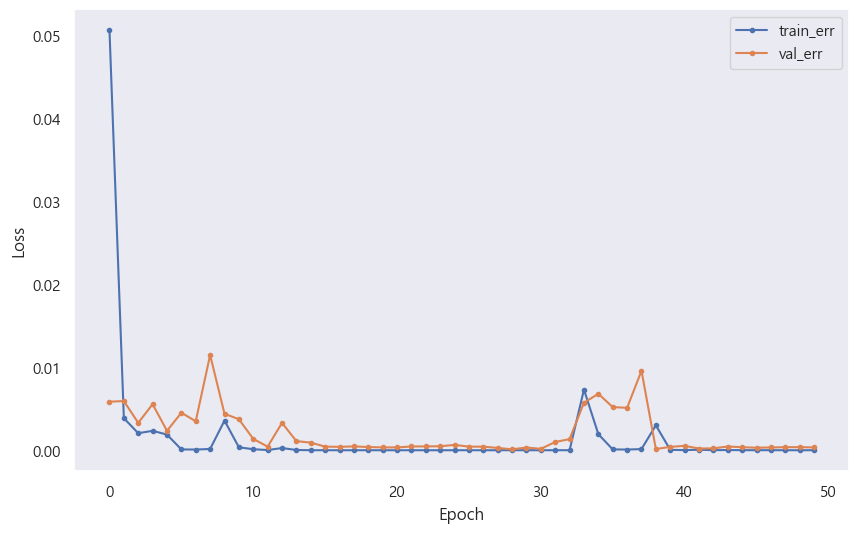

In [75]:
# 학습곡선
dl_history_plot(history1.history)

In [76]:
# 예측 및 평가
y_pred1 = dynamic_binary_model1.predict(X_test)  
y_pred_classes1 = (y_pred1 > 0.5).astype(int)

acc1 = accuracy_score(y_test, y_pred_classes1)
print(f"Accuracy Score: {acc1:.4f}")

print(classification_report(y_test, y_pred_classes1))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471



#### 2) 모델2

In [80]:
# 모델 설계
clear_session()
dynamic_binary_model2 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [81]:
# 컴파일 및 학습
dynamic_binary_model2.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history2 = dynamic_binary_model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9613 - loss: 0.0938 - val_accuracy: 0.9983 - val_loss: 0.0066
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0067 - val_accuracy: 0.9992 - val_loss: 0.0049
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9981 - loss: 0.0057 - val_accuracy: 0.9992 - val_loss: 0.0042
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0033 - val_accuracy: 0.9992 - val_loss: 0.0042
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 5.9470e-04 - val_accuracy: 0.9992 - val_loss: 0.0051
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9994 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 1.8445e-04
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9991 - loss: 0.0028 - val_accu

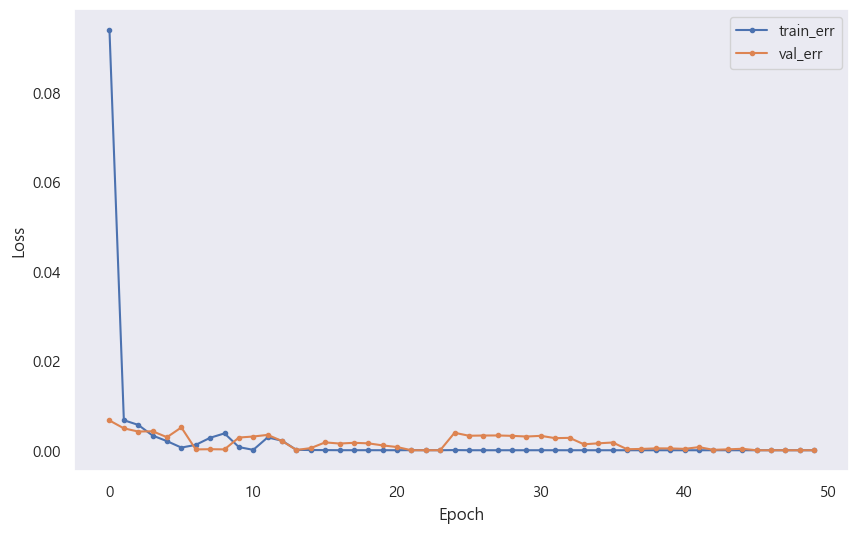

In [82]:
# 학습곡선
dl_history_plot(history2.history)

In [83]:
# 예측 및 평가
y_pred2 = dynamic_binary_model2.predict(X_test)  
y_pred_classes2 = (y_pred2 > 0.5).astype(int)

acc2 = accuracy_score(y_test, y_pred_classes1)
print(f"Accuracy Score: {acc2:.4f}")

print(classification_report(y_test, y_pred_classes2))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00       638

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471



### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
# (tip) 정적 행동(0)인 데이터 추출
train_static = train_df[train_df['is_dynamic'] == 0].copy()
test_static  = test_df[test_df['is_dynamic'] == 0].copy()

In [28]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑핑
static_actions = ['LAYING', 'SITTING', 'STANDING']
static_map = {action: i for i, action in enumerate(static_actions)}

train_static['Activity_label'] = train_static['Activity'].map(static_map)
test_static['Activity_label']  = test_static['Activity'].map(static_map)

cols = ['Activity', 'Activity_label', 'is_dynamic']
X_train_static = train_static.drop(columns=cols, errors='ignore')
y_train_static = train_static['Activity_label']

X_test_static  = test_static.drop(columns=cols, errors='ignore')
y_test_static  = test_static['Activity_label']

In [43]:
# 모델 설계
clear_session()
static_model1 = Sequential([
    Input(shape=(X_train_static.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train_static)), activation='softmax')
])

In [44]:
# 컴파일 및 학습
static_model1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_static1 = static_model1.fit(
    X_train_static, y_train_static,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1
)

Epoch 1/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4101 - loss: 1.0818 - val_accuracy: 0.6909 - val_loss: 0.8979
Epoch 2/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5934 - loss: 0.8728 - val_accuracy: 0.7434 - val_loss: 0.5467
Epoch 3/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7178 - loss: 0.6052 - val_accuracy: 0.7651 - val_loss: 0.4429
Epoch 4/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7522 - loss: 0.4986 - val_accuracy: 0.7821 - val_loss: 0.4017
Epoch 5/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7716 - loss: 0.4542 - val_accuracy: 0.8594 - val_loss: 0.3459
Epoch 6/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8264 - loss: 0.3949 - val_accuracy: 0.8779 - val_loss: 0.2883
Epoch 7/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8376 - loss: 0.3664 - val_accuracy: 0.8856 - val_loss: 0.2708
Epoch 8/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8682 - loss: 0.3270 - val_accuracy: 0.8980 - v

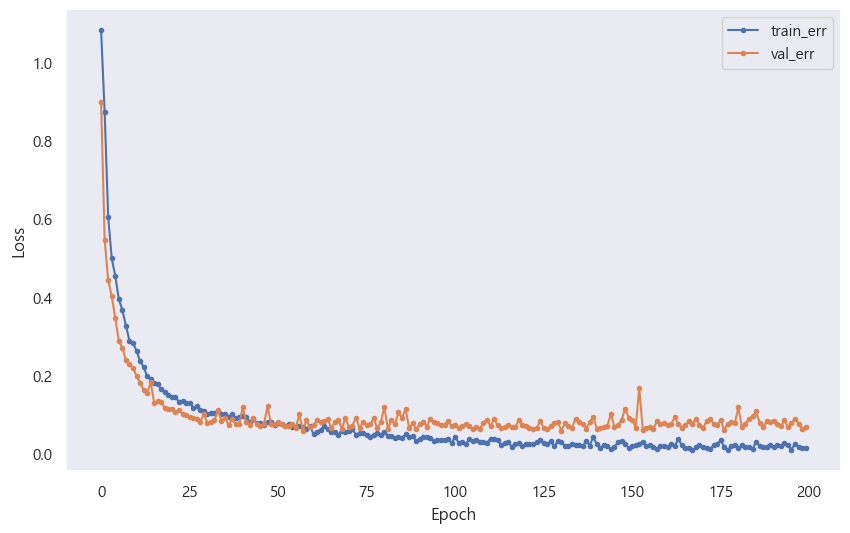

In [45]:
# 학습곡선
dl_history_plot(history_static1.history)

In [ ]:
# 예측 및 평가
y_pred3 = static_model1.predict(X_test_static)  
y_pred_classes3 = y_pred3.argmax(axis=1) 

acc3 = accuracy_score(y_test_static, y_pred_classes3)
print(f"Accuracy Score: {acc3:.4f}")

print(classification_report(y_test_static, y_pred_classes3))

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy Score: 0.9688
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       292
           1       0.93      0.97      0.95       254
           2       0.97      0.94      0.96       287

    accuracy                           0.97       833
   macro avg       0.97      0.97      0.97       833
weighted avg       0.97      0.97      0.97       833



#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [67]:
# (tip) 동적 행동(1)인 데이터 추출
train_dynamic = train_df[train_df['is_dynamic'] == 1].copy()
test_dynamic  = test_df[test_df['is_dynamic'] == 1].copy()

In [68]:
# (tip) map 활용해서 숫자레이블로 매핑핑
dynamic_actions = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
dynamic_map = {action: i for i, action in enumerate(dynamic_actions)}

train_dynamic['Activity_label'] = train_dynamic['Activity'].map(dynamic_map)
test_dynamic['Activity_label']  = test_dynamic['Activity'].map(dynamic_map)

cols = ['Activity', 'Activity_label', 'is_dynamic']
X_train_dynamic = train_dynamic.drop(columns=cols, errors='ignore')
y_train_dynamic = train_dynamic['Activity_label']

X_test_dynamic  = test_dynamic.drop(columns=cols, errors='ignore')
y_test_dynamic  = test_dynamic['Activity_label']

In [69]:
# 모델 설계
clear_session()
dynamic_activity_model = Sequential([
    Input(shape=(X_train_dynamic.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train_dynamic)), activation='softmax')
])

In [70]:
# 컴파일 및 학습
dynamic_activity_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_dynamic_activity = dynamic_model1.fit(
    X_train_dynamic, y_train_dynamic,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1
)

Epoch 1/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.0099e-04 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.2279e-04 - val_accuracy: 0.9981 - val_loss: 0.0027
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.4731e-04 - val_accuracy: 0.9981 - val_loss: 0.0049
Epoch 4/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0012 - val_accuracy: 0.9981 - val_loss: 0.0032
Epoch 5/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.7879e-05 - val_accuracy: 0.9981 - val_loss: 0.0030
Epoch 6/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.3663e-05 - val_accuracy: 0.9981 - val_loss: 0.0022
Epoch 7/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 2.2587e-05 - val_accuracy: 0.9981 - val_loss: 0.0022
Epoch 8/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.7008e-0

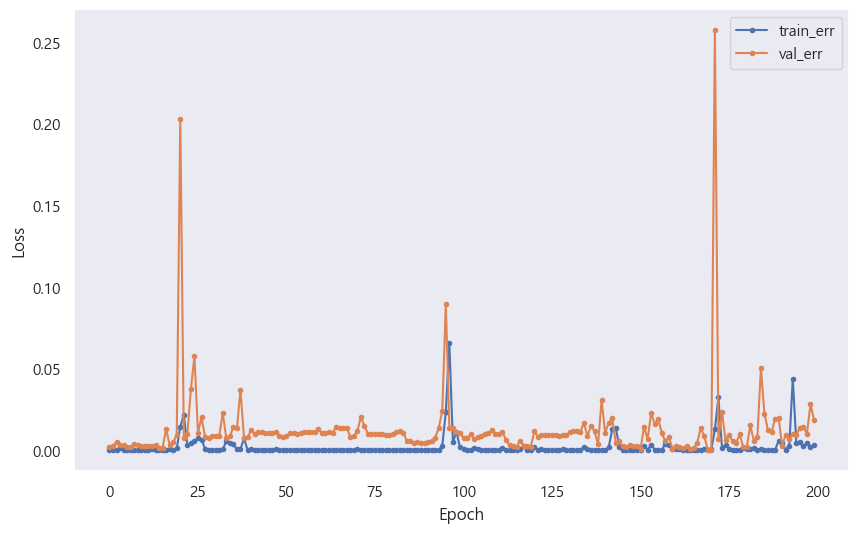

In [71]:
# 학습곡선
dl_history_plot(history_dynamic_activity.history)

In [72]:
# 예측 및 평가
y_pred4 = dynamic_activity_model.predict(X_test_dynamic)  
y_pred_classes4 = y_pred4.argmax(axis=1) 

acc4 = accuracy_score(y_test_dynamic, y_pred_classes4)
print(f"Accuracy Score: {acc4:.4f}")

print(classification_report(y_test_dynamic, y_pred_classes4))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy Score: 0.3558
              precision    recall  f1-score   support

           0       0.36      0.98      0.52       228
           1       0.29      0.02      0.03       215
           2       0.00      0.00      0.00       195

    accuracy                           0.36       638
   macro avg       0.21      0.33      0.19       638
weighted avg       0.22      0.36      0.20       638



c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [92]:
#(tip) 함수 만들기
# 1. 전처리
path = './data/'
train_df = pd.read_csv(path + 'data01_train.csv')
test_df = pd.read_csv(path + 'data01_test.csv')

# 불필요한 칼럼을 삭제하세요.
train_df = train_df.drop(columns=['subject'])
test_df = test_df.drop(columns=['subject'])

# 데이터 분리
X_test = test_df.drop(columns=['Activity'])
y_test = test_df['Activity']

In [93]:
# 이진분류 모델 학습 데이터
dynamic_map = {
    'LAYING': 0,
    'SITTING': 0,
    'STANDING': 0,
    'WALKING': 1,
    'WALKING_UPSTAIRS': 1,
    'WALKING_DOWNSTAIRS': 1
}

X_dynamic_binary = train_df.drop(columns=['Activity'])
y_dynamic_binary = train_df['Activity'].map(dynamic_map)

X_train_dynamic_binary, X_val_dynamic_binary, y_train_dynamic_binary, y_val_dynamic_binary = train_test_split(
    X_dynamic_binary, y_dynamic_binary, 
    test_size=0.2, 
    random_state=42,
    stratify=y_dynamic_binary
)

# 스케일링
scaler = MinMaxScaler()
X_train_dynamic_binary = scaler.fit_transform(X_train_dynamic_binary)
X_val_dynamic_binary   = scaler.transform(X_val_dynamic_binary)

In [94]:
# 정적 활동 다중분류 모델 학습 데이터
train_static = train_df[train_df['Activity'].isin(['LAYING', 'SITTING', 'STANDING'])].copy()
test_static  = test_df[test_df['Activity'].isin(['LAYING', 'SITTING', 'STANDING'])].copy()

static_map = {
    'LAYING': 0,
    'SITTING': 1,
    'STANDING': 2
}

X_static_multi_train = train_static.drop(columns=['Activity'])
y_static_multi_train = train_static['Activity'].map(static_map)

X_train_static_multi, X_val_static_multi, y_train_static_multi, y_val_static_multi = train_test_split(
    X_static_multi_train, y_static_multi_train,
    test_size=0.2,
    random_state=42,
    stratify=y_static_multi_train
)

# 스케일링
scaler = MinMaxScaler()
X_train_static_multi = scaler.fit_transform(X_train_static_multi)
X_val_static_multi   = scaler.transform(X_val_static_multi)

In [96]:
# 동적 활동 다중분류 모델 학습 데이터
train_dynamic = train_df[train_df['Activity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])].copy()
test_dynamic  = test_df[test_df['Activity'].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])].copy()

dynamic_map = {
    'WALKING': 3,
    'WALKING_UPSTAIRS': 4,
    'WALKING_DOWNSTAIRS': 5
}

X_dynamic_multi_train = train_dynamic.drop(columns=['Activity'])
y_dynamic_multi_train = train_dynamic['Activity'].map(dynamic_map)

X_train_dynamic_multi, X_val_dynamic_multi, y_train_dynamic_multi, y_val_dynamic_multi = train_test_split(
    X_dynamic_multi_train, y_dynamic_multi_train,
    test_size=0.2,
    random_state=42,
    stratify=y_dynamic_multi_train
)

scaler = MinMaxScaler()
X_train_dynamic_multi = scaler.fit_transform(X_train_dynamic_multi)
X_val_dynamic_multi   = scaler.transform(X_val_dynamic_multi)


In [ ]:
activity_map = {
    'LAYING': 0,
    'SITTING': 1,
    'STANDING': 2,
    'WALKING': 3,
    'WALKING_UPSTAIRS': 4,
    'WALKING_DOWNSTAIRS': 5
}

y_test = y_test.map(activity_map)

# 스케일링
scaler_test = MinMaxScaler()
X_test = scaler_test.fit_transform(X_test)

### 모델 준비

In [ ]:
clear_session()
# 활동여부 이진 분류 모델
dynamic_model_binary = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') 
])

dynamic_model_binary.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

dynamic_model_binary.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=0
)


# 정적 활동 다중 분류
static_model_multi = Sequential([
    Input(shape=(X_train_static.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train_static)), activation='softmax')
])

# 컴파일 및 학습
static_model_multi.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

static_model_multi = static_model_multi.fit(
    X_train_static, y_train_static,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=0
)


# 동적 활동 다중 분류
dynamic_model_multi = Sequential([
    Input(shape=(X_train_dynamic.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train_dynamic)), activation='softmax')
])

# 컴파일 및 학습
dynamic_model_multi.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

dynamic_model_multi.fit(
    X_train_dynamic, y_train_dynamic,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=0
)

In [ ]:
# 2. 예측하기
# 2-1. 단계1을 모델로 0,1 구분


# 2-2. 단계 1의 결과로 데이터 나누기
# 2-3. 단계2 모델로 예측
# 2-4. 예측 결과 원래 값으로 변환
# 2-5. 하나로 합쳐보기
#-------------------
# 3. 최종 성능평가 하기

In [ ]:
# (옵션) 위 참고해서 분류모델 파이프라인 만들어보기

#### 2) test 셋으로 예측하고 평가하기

In [ ]:
# test 셋의 구조 한번 확인해보고 성능평가 해보기